In [1]:
import math
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error
from scipy.stats import beta, burr, t, rdist, skewnorm, uniform
from sklearn.model_selection import train_test_split
from scipy.stats.distributions import norm
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
import networkx as nx
import pgmpy
import bnlearn as bn
from pgmpy.estimators import HillClimbSearch, K2Score, BicScore
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG
from pgmpy.inference import VariableElimination

In [2]:
data = pd.read_csv('./btc2.csv').drop(['dt'],axis=1).dropna()


## *Subtask 1*
target variables for subsampling = ['MACD','Volume','RSI']

In [3]:
for col in ['quantile_Volume','quantile_RSI','quantile_STOCHRSI-K','quantile_STOCHRSI-D']:
    col_map = {}

    for value,index in enumerate(data[col].unique()):
        col_map[index] = value

    data[col] = data[col].map(col_map)



In [7]:
def inverse_transform_sampling(n, dist, param):
    gen=np.random.uniform(size=n)                                       
    rv=dist(*param)
    return rv.ppf(gen)


def accept_rejection_sampling(real_distibution, real_distibution_params, synth_distr, synth_distr_params, a, b, iterations):
    def real_pdf(x):
        return real_distibution.pdf(x, *real_distibution_params)

    def synth_pdf(x):
        return synth_distr.pdf(x,*synth_distr_params)

    x = np.linspace(a, b, 2000)
    coef = max(real_pdf(x) / synth_pdf(x))
    result = []
    print(coef)
    for i in range(iterations):
        z = synth_distr.rvs(*synth_distr_params, size=1)
        u = np.random.uniform(0, coef*synth_pdf(z))

        if u <= real_pdf(z):
            result.append(z)

    return np.array(result)



In [8]:
['MACD','Volume','RSI']
rsi_param= beta.fit(data['RSI'])
volume_param = burr.fit(data['Volume'])
macd_param = t.fit(data['MACD'])

sample_rsi=inverse_transform_sampling(10000,beta, rsi_param)
sample_volume=inverse_transform_sampling(10000,burr, volume_param)
sample_macd=inverse_transform_sampling(10000,t,macd_param)



Text(0.5, 0.98, 'Inverse-transform')

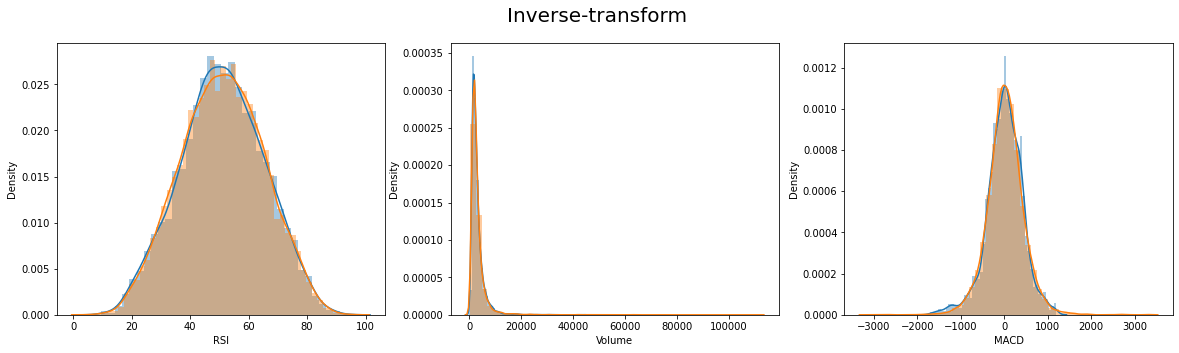

In [9]:
fig, axs = plt.subplots(1,3, figsize=(20, 5))
sns.distplot(data.RSI,kde=True, label='initial data', ax=axs[0])
sns.distplot(sample_rsi,kde=True, norm_hist=True,label='sampled data',ax=axs[0])

sns.distplot(data.Volume,kde=True, norm_hist=True,label='initial data', ax=axs[1])
sns.distplot(sample_volume,kde=True, norm_hist=True,label='sampled data',ax=axs[1])

sns.distplot(data.MACD,kde=True, norm_hist=True,label='initial data', ax=axs[2])
sns.distplot(sample_macd,kde=True, norm_hist=True,label='sampled data',ax=axs[2])

plt.suptitle('Inverse-transform',fontsize=20)

1.1498563767856815
173.17403978968812
18.5098575659041


Text(0.5, 0.98, 'Accept-reject sampling')

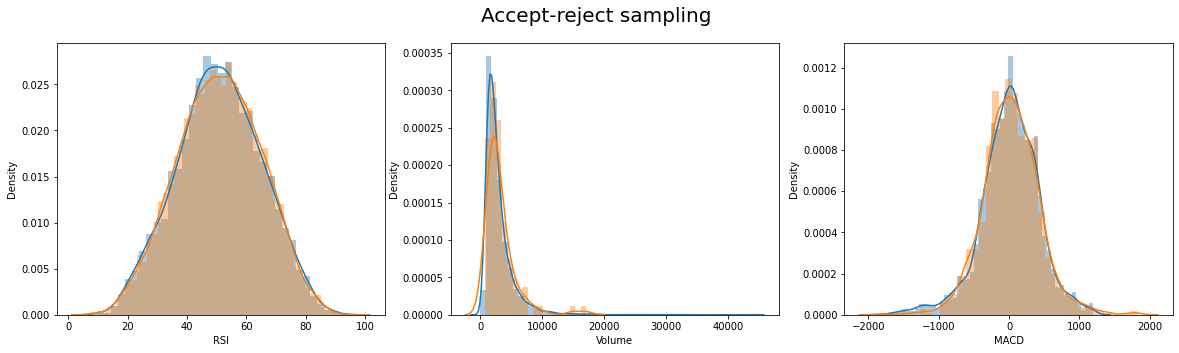

In [10]:

fig, axs = plt.subplots(1,3, figsize=(20, 5))
sns.distplot(data.RSI, label='initial data', ax=axs[0])
sns.distplot(accept_rejection_sampling(beta, rsi_param, norm, (50.971707356611425, 14.1904533328931), data.RSI.min(), data.RSI.max(),20000),label='sampled data',ax=axs[0])

sns.distplot(data.Volume, label='initial data', ax=axs[1])
sns.distplot(accept_rejection_sampling(burr, volume_param, uniform, (5.887034, 442355), data.Volume.min(), data.Volume.max(), 20000),label='sampled data',ax=axs[1])

sns.distplot(data.MACD, label='initial data', ax=axs[2])
sns.distplot(accept_rejection_sampling(t, macd_param, norm, (10, 415), data.MACD.min(), data.MACD.max(),20000),label='sampled data',ax=axs[2])



plt.suptitle('Accept-reject sampling',fontsize=20)

In [248]:
data.corr()

,Open,High,Low,Close,Volume,STOCHRSI-K,STOCHRSI-D,RSI,MACD,MACD Signal,MACD Diff,quantile_Volume,quantile_RSI,quantile_STOCHRSI-K,quantile_STOCHRSI-D,month
Open,1.000000,0.999436,0.999122,0.998911,-0.163601,-0.013026,-0.008452,0.129210,0.175072,0.185601,0.002390,-0.139912,-0.115465,0.002503,0.000893,0.207690
High,0.999436,1.000000,0.998679,0.999394,-0.146901,-0.009436,-0.007578,0.135135,0.170554,0.179966,0.004913,-0.125892,-0.118289,0.000085,0.000396,0.202216
Low,0.999122,0.998679,1.000000,0.999302,-0.190688,-0.005936,-0.004146,0.145587,0.185774,0.193522,0.013012,-0.156469,-0.128506,-0.002452,-0.002017,0.215473
Close,0.998911,0.999394,0.999302,1.000000,-0.167481,-0.005388,-0.005864,0.147130,0.177824,0.185705,0.011034,-0.140575,-0.128144,-0.002450,-0.000715,0.209054
Volume,-0.163601,-0.146901,-0.190688,-0.167481,1.000000,-0.049003,-0.046398,-0.170368,-0.262660,-0.234993,-0.136546,0.675092,0.199713,0.067739,0.052584,-0.315941
STOCHRSI-K,-0.013026,-0.009436,-0.005936,-0.005388,-0.049003,1.000000,0.944063,0.579636,0.076995,-0.175994,0.789144,0.000249,-0.416526,-0.799344,-0.748931,-0.004172
STOCHRSI-D,-0.008452,-0.007578,-0.004146,-0.005864,-0.046398,0.944063,1.000000,0.546452,0.141531,-0.116347,0.816854,-0.002699,-0.384739,-0.754330,-0.796192,-0.004943
RSI,0.129210,0.135135,0.145587,0.147130,-0.170368,0.579636,0.546452,1.000000,0.717709,0.540135,0.685064,-0.101072,-0.723392,-0.439144,-0.404310,0.126370
MACD,0.175072,0.170554,0.185774,0.177824,-0.262660,0.076995,0.141531,0.717709,1.000000,0.951774,0.345162,-0.167068,-0.533356,-0.072908,-0.114627,0.207825
MACD Signal,0.185601,0.179966,0.193522,0.185705,-0.234993,-0.175994,-0.116347,0.540135,0.951774,1.000000,0.040571,-0.172811,-0.412780,0.117693,0.075353,0.223398
